<a href="https://www.kaggle.com/code/evelynartoria/digit-recognizer-with-flat-model?scriptVersionId=186893335" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Import needed libraries

In [2]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

# Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to --> {device}")

default device set to --> cpu


In [4]:
!pwd

/kaggle/working


In [5]:
test_csv = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train_csv = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_csv

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Turn each row of pixels into an image

label is 8


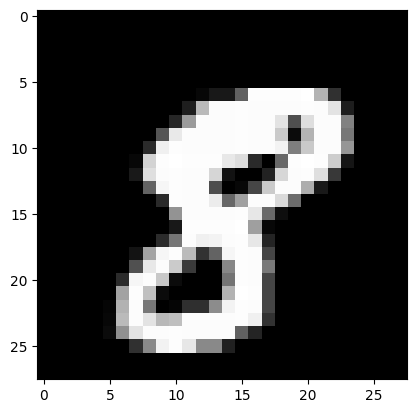

In [6]:
x = 10
pixels = train_csv.iloc[x, 1:].values # values from x row starting at index 1 to avoid the labels
label = train_csv["label"][x]
#print(f"image label is {csv['label']}")
print(f"label is {label}")
plt.imshow(pixels.reshape(28, 28), cmap="gray")

# Function for turning the data into a dataset

In [7]:
def make_dataset(csv, train: bool):
    images = []
    labels = []
    for row in range(len(csv)):
        if train:
            pixels = csv.iloc[row, 1:].values
        else:
            pixels = csv.iloc[row].values
        image = pixels.reshape(1, 28, 28)
        label = train_csv["label"][row]
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    
    if train:
        print(f"train images data shape --> {images.shape}")
        print(f"train images labels shape --> {labels.shape}")
    else:
        print(f"train images data shape --> {images.shape}")
        print(f"train images labels shape --> {labels.shape}")
    
    images_tensor = torch.tensor(images, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)
    return dataset

In [8]:
train_dataset = make_dataset(csv=train_csv, train=True)
test_dataset = make_dataset(csv=test_csv, train=False)
print(len(train_dataset))
print(len(test_dataset))

train images data shape --> (42000, 1, 28, 28)
train images labels shape --> (42000,)
train images data shape --> (28000, 1, 28, 28)
train images labels shape --> (28000,)
42000
28000


# Data visualization

In [9]:
def show_image(tensor):
    plt.imshow(tensor.permute(1, 2, 0), cmap="gray")

def show_random_image(dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    show_image(dataset[x][0])
    print(f"image label is {dataset[x][1]}")

image label is 3


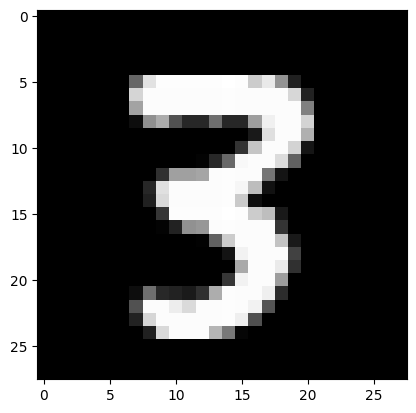

In [10]:
show_random_image(dataset=train_dataset)

# Create a dataloader for batched training

In [11]:
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, generator=torch.Generator(device=device))
test_dataloader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=BATCH_SIZE, generator=torch.Generator(device=device))

# Create a base model (in this case I will use a flat model)

In [12]:
class FlatModel(nn.Module):
    def __init__(self, width, height, n_classes):
        super().__init__()
        
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=width*height, out_features=8*8, dtype=torch.float32)
        self.linear2 = nn.Linear(in_features=8*8, out_features=8*8*8, dtype=torch.float32)
        self.linear3 = nn.Linear(in_features=8*8*8, out_features=n_classes, dtype=torch.float32)
        
        self.act_fn = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flat(x)
        x = self.act_fn(self.linear1(x))
        x = self.act_fn(self.linear2(x))
        x = self.linear3(x)
        
        return x

# Define the model, optimizer and loss function

In [13]:
model = FlatModel(width=28, height=28, n_classes=10)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training loop

In [14]:
def train_model(model, train_dataloader, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        for batch, (images, labels) in tqdm(enumerate(train_dataloader)):
            images.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 50 == 0:
                print(f"batch {batch} loss --> {loss}")
    print(f"last batch loss --> {loss}")

In [15]:
train_model(model=model, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=1)

21it [00:00, 110.42it/s]

batch 0 loss --> 14.770580291748047


82it [00:00, 175.54it/s]

batch 50 loss --> 0.4794609844684601


124it [00:00, 190.54it/s]

batch 100 loss --> 0.4852997660636902


187it [00:01, 199.86it/s]

batch 150 loss --> 0.2665521502494812


229it [00:01, 200.10it/s]

batch 200 loss --> 0.17796701192855835


270it [00:01, 195.20it/s]

batch 250 loss --> 0.24345067143440247


329it [00:01, 179.45it/s]

batch 300 loss --> 0.19726529717445374
last batch loss --> 0.10738138109445572


# Predict with model

In [16]:
def model_predict(model, dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    with torch.inference_mode():
        image = dataset[x][0]
        show_image(image)
        logits = model(image)
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        print(f"model predicted --> {pred.item()}")

    print(f"label is {dataset[x][1]}")

model predicted --> 0
label is 0


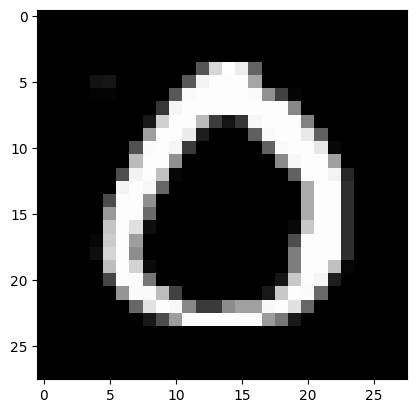

In [17]:
model_predict(model=model, dataset=train_dataset)

# Make predictions from test dataset

In [18]:
images_ids = []
preds = []
for idx, (image, label) in enumerate(test_dataset):
    logits = model(image)
    pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    preds.append(pred.item())
    images_ids.append(idx+1) # must start at 1 instead of 0 
    

In [19]:
!mkdir /kaggle/working/submissions

In [20]:
df = pd.DataFrame(
    {
        "ImageId": images_ids,
        "Label": preds
    }
)
csv_file_path = "./submission.csv"
df.to_csv(csv_file_path, index=False)